# Musical instrument sound classification from Audio 

#### This cell block will contain all the import statements


In [32]:
#General
import numpy as np
import itertools
import pandas as pd
import math
import os
import IPython
os.environ['NUMBA_CACHE_DIR'] = IPython.paths.get_ipython_cache_dir()

# System
import os, fnmatch

# Visualization
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image
from IPython.display import Audio

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,MaxPooling2D, Dense, Dropout,Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard  # Ensure TensorBoard is imported
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model

# Audio
import librosa.display
from librosa.util import normalize as normalize
import IPython.display as ipd
import librosa
import librosa.display

# Random Seed
# Set random seed for TensorFlow
tf.random.set_seed(0)

# Set random seed for numpy
np.random.seed(0)

# Configurations
path='./audio/'

# Display CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10950407304610151574
xla_global_id: -1
]


C:\Windows\Temp\ipykernel_66344\2497090275.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display, Image


#### Here are some parameters required for signal processing and machine learning

In [33]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

#### In this cell the code iterates over all the `.mp3` files in the specified directory (`path`) and its subdirectories. For each file, it extracts its file path, determines its label based on predefined instrument classes, trims silence, calculates its duration, and stores the file path, label, and duration in separate lists (`files`, `labels`, `duration`). Additionally, if a file fails to load or has insufficient data, it prints an error message and continues to the next file. Finally, it prints the total number of audio files found along with their paths, labels, and durations.

#### this is the datasetlink I got all the dataset and i have selected few of the orchestral instrument from this dataset https://philharmonia.co.uk/resources/sound-samples/

In [74]:
files = []
labels = []
duration = []
classes = ['contrabassoon','flute', 'sax', 'oboe', 'cello', 'trumpet', 'viola','mandolin']

for root, dirnames, filenames in os.walk(path):
    for i, filename in enumerate(fnmatch.filter(filenames, '*.mp3')):
        file_path = os.path.join(root, filename)
        files.append(file_path)
        matched = False
        for name in classes:
            if fnmatch.fnmatchcase(filename, '*' + name + '*'):
                labels.append(name)
                matched = True
                break
        if not matched:
            labels.append('other')
        
        print(f"Get {i+1} = {filename}")
        try:
            y, sr = librosa.load(file_path, sr=fs)
            if len(y) < 2:
                print(f"Error loading {filename}: insufficient data")
                continue
            yt, index = librosa.effects.trim(y, top_db=60)  # Trim silence
            duration.append(librosa.get_duration(y = yt, sr=fs))
        except Exception as e:
            print(f"Error loading {filename}. Error: {e}")

print(f"Found {len(files)} audio files in {path}")


Get 1 = cello_A2_025_forte_arco-normal.mp3
Get 2 = cello_A2_025_fortissimo_arco-normal.mp3
Get 3 = cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 4 = cello_A2_025_mezzo-piano_arco-normal.mp3
Get 5 = cello_A2_025_pianissimo_arco-normal.mp3
Get 6 = cello_A2_05_forte_arco-normal.mp3
Get 7 = cello_A2_05_fortissimo_arco-normal.mp3
Get 8 = cello_A2_05_mezzo-piano_arco-normal.mp3
Get 9 = cello_A2_05_pianissimo_arco-normal.mp3
Get 10 = cello_A2_15_forte_arco-normal.mp3
Get 11 = cello_A2_15_pianissimo_arco-normal.mp3
Get 12 = cello_A2_15_piano_arco-normal.mp3
Get 13 = cello_A2_1_forte_arco-normal.mp3
Get 14 = cello_A2_1_fortissimo_arco-normal.mp3
Get 15 = cello_A2_1_mezzo-piano_arco-normal.mp3
Get 16 = cello_A2_1_mezzo-piano_non-vibrato.mp3
Get 17 = cello_A2_1_pianissimo_arco-normal.mp3
Get 18 = cello_A3_025_forte_arco-normal.mp3
Get 19 = cello_A3_025_fortissimo_arco-normal.mp3
Get 20 = cello_A3_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 21 = cello_A3_025_mezzo-piano_arco-normal.mp

In [36]:
print("Max. Duration:", max(duration))
print("Min. Duration:", min(duration))
print("Average Duration:", np.mean(duration))

Max. Duration: 27.704308390022675
Min. Duration: 0.22058956916099773
Average Duration: 1.5068857491714636


#### This code iterates over the list of audio file paths (`files`). For each file, it loads the audio data using librosa, trims any silent sections using a threshold of 60 decibels, and calculates the duration of the trimmed audio. If an error occurs during loading or processing, it prints an error message. Finally, it prints the total number of durations calculated.

In [37]:
# Load audio files, trim silence and calculate duration
duration = []
for i,f in enumerate(files):
    print ("Get %d  %s"%(i+1, f))
    try:
        y, sr = librosa.load(f, sr=fs)
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        #y/=y.max() #Normalize
        yt, index = librosa.effects.trim(y,top_db=60) #Trim
        duration.append(librosa.get_duration(y = yt, sr=fs))
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d Durations"%len(duration))

Get 1  ./audio/cello\cello_A2_025_forte_arco-normal.mp3
Get 2  ./audio/cello\cello_A2_025_fortissimo_arco-normal.mp3
Get 3  ./audio/cello\cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 4  ./audio/cello\cello_A2_025_mezzo-piano_arco-normal.mp3
Get 5  ./audio/cello\cello_A2_025_pianissimo_arco-normal.mp3
Get 6  ./audio/cello\cello_A2_05_forte_arco-normal.mp3
Get 7  ./audio/cello\cello_A2_05_fortissimo_arco-normal.mp3
Get 8  ./audio/cello\cello_A2_05_mezzo-piano_arco-normal.mp3
Get 9  ./audio/cello\cello_A2_05_pianissimo_arco-normal.mp3
Get 10  ./audio/cello\cello_A2_15_forte_arco-normal.mp3
Get 11  ./audio/cello\cello_A2_15_pianissimo_arco-normal.mp3
Get 12  ./audio/cello\cello_A2_15_piano_arco-normal.mp3
Get 13  ./audio/cello\cello_A2_1_forte_arco-normal.mp3
Get 14  ./audio/cello\cello_A2_1_fortissimo_arco-normal.mp3
Get 15  ./audio/cello\cello_A2_1_mezzo-piano_arco-normal.mp3
Get 16  ./audio/cello\cello_A2_1_mezzo-piano_non-vibrato.mp3
Get 17  ./audio/cello\cello_A2_1_pianissi

##### This code visualizes the distribution of audio file durations stored in the `duration` list using a histogram. The histogram is plotted with 40 bins, providing insights into the frequency distribution of different duration ranges. Additionally, it calculates and prints the average duration of the audio files, rounded to two decimal places. The visualization and average duration provide a summary of the dataset's temporal characteristics, aiding in further analysis or understanding of the audio files.

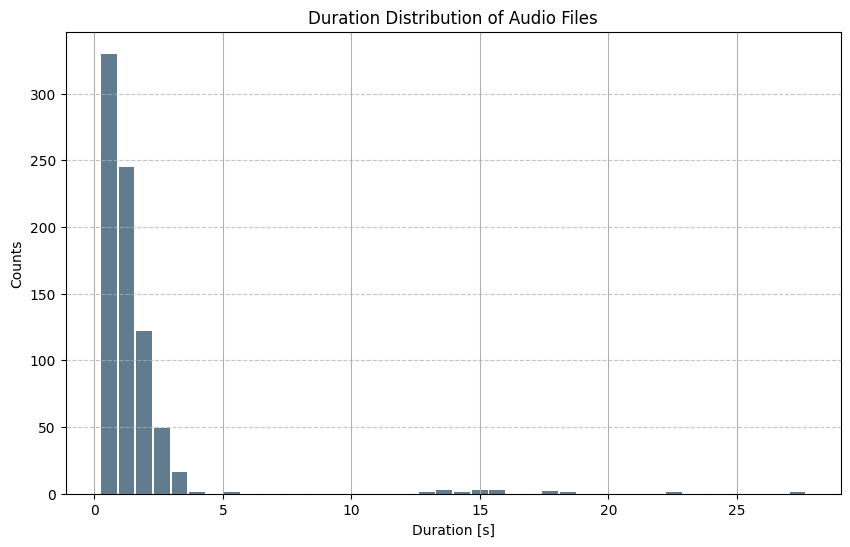

Duration average: 1.51 seconds


In [38]:
# Assuming 'duration' is already defined and filled with audio file durations
durationDist = pd.Series(np.array(duration))

# Creating the histogram
plt.figure(figsize=(10, 6))  # Added figure size for better visibility
durationDist.plot.hist(grid=True, bins=40, rwidth=0.9, color='#607c8e')
plt.title('Duration Distribution of Audio Files')
plt.xlabel('Duration [s]')
plt.ylabel('Counts')
plt.grid(axis='y', linestyle='--', alpha=0.75)  # Adjusted grid style for aesthetics
plt.show()  # Explicitly calling show to ensure the plot displays in all environments

# Calculating and printing the average duration
average_duration = np.mean(duration)
print(f"Duration average: {average_duration:.2f} seconds")


##### This code segment loads a specified audio file (`files[10]`) using librosa, limiting the duration to 1 second. It then normalizes the audio data, pads or truncates it to ensure it exactly fits the desired duration, and computes the Short-Time Fourier Transform (STFT) spectrogram. The resulting spectrogram is displayed using matplotlib, with logarithmic frequency axis and time axis. Additionally, it prints the shape of the spectrogram array and plays back the audio. This provides both a visual representation of the audio's frequency content over time and allows for audio playback for further inspection.

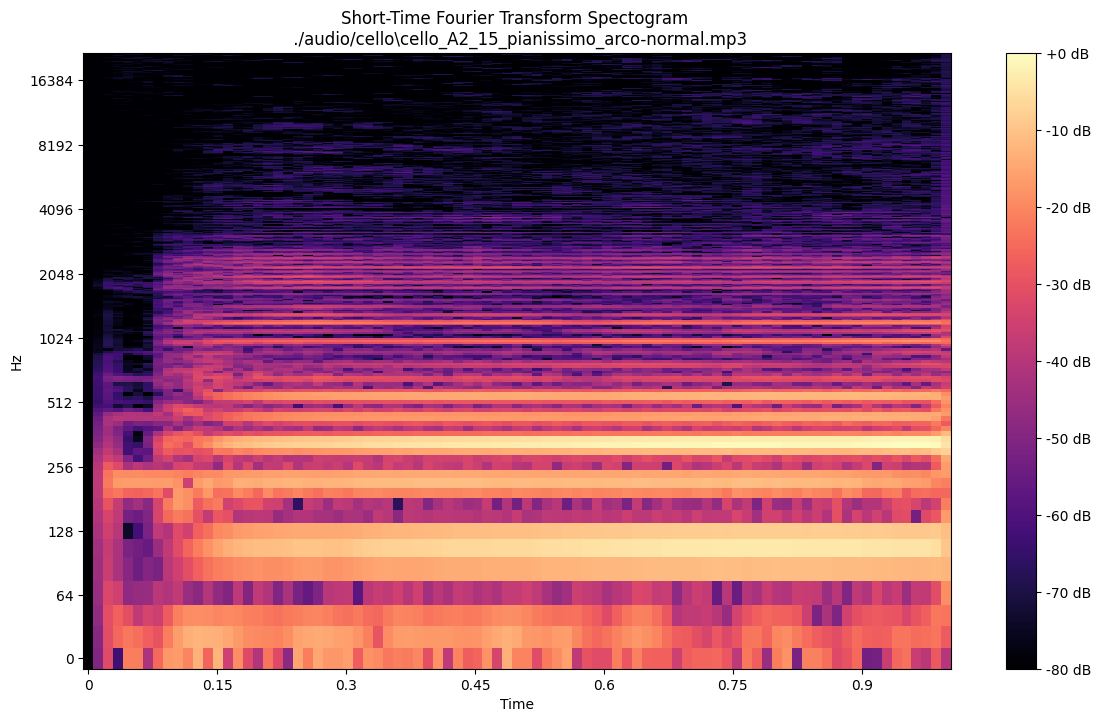

Spectrogram Array Shape: (1025, 87)


In [39]:
# Load the specified audio file
y, sr = librosa.load(files[10], sr=fs, duration=1)  # Load 1 second of audio
y /= np.max(np.abs(y))  # Normalize

# Ensure the audio length is exactly 1 second
duration_in_samples = librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(data=y, size=duration_in_samples)

# Compute STFT
y_stft = librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
y_spec = librosa.amplitude_to_db(abs(y_stft), ref=np.max)

# Plotting the spectrogram
plt.figure(figsize=(14, 8))
plt.title(f"Short-Time Fourier Transform Spectogram \n {files[10]}")
librosa.display.specshow(y_spec, sr=fs, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

print("Spectrogram Array Shape:", y_spec.shape)

# Playback the audio
Audio(y, rate=sr)


##### This code snippet performs label encoding and one-hot encoding on the categorical labels stored in the `labels` list. Firstly, it uses `LabelEncoder` from scikit-learn to encode the labels into numerical representations. Then, it applies one-hot encoding using `OneHotEncoder`, transforming the numerical labels into binary vectors. Finally, it prints the shape of the one-hot encoded labels array and an example of a one-hot encoded label. This process prepares the categorical labels for use in machine learning models that require numerical inputs.

In [40]:
# Assuming 'labels' is already defined and filled with your categorical data
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

# One-Hot Encoding
encoder = OneHotEncoder()
onehot_labels = encoder.fit_transform(classes_num.reshape(-1, 1)).toarray()  # Producing a dense array

# Optionally, verify the shape and content of the one-hot encoded labels
print("Shape of one-hot encoded labels:", onehot_labels.shape)
print("Example of one-hot encoded label:", onehot_labels[0])


8 classes: cello, contrabassoon, flute, mandolin, oboe, sax, trumpet, viola
Shape of one-hot encoded labels: (780, 8)
Example of one-hot encoded label: [1. 0. 0. 0. 0. 0. 0. 0.]


##### This code block utilizes scikit-learn's `StratifiedShuffleSplit` to split the dataset into training and testing sets while maintaining class distribution. It then iterates over the splits and assigns the file paths and corresponding one-hot encoded labels to the training and testing sets. Debugging print statements are included to verify the sizes of the training and testing sets. Finally, assertions are used to ensure that the train and test sets are well-formed and aligned, checking that the number of files and labels match in each set. This process ensures that the dataset is properly split for training and evaluation purposes.

In [41]:
# Convert list of file paths to a numpy array for efficient indexing
files_arr = np.array(files)

# Prepare the stratified shuffle split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(files_arr, onehot_labels)  # Ensure onehot_labels align with files

for train_index, test_index in splits:
    train_set_files = files_arr[train_index]
    test_set_files = files_arr[test_index]
    train_classes = onehot_labels[train_index]
    test_classes = onehot_labels[test_index]

    # Debugging print statements to verify the distribution
    print(f"Training set size: {len(train_set_files)}")
    print(f"Test set size: {len(test_set_files)}")
    # Optionally, add more detailed checks or statistics here

# Ensure the train and test sets are well-formed and aligned
assert len(train_set_files) == len(train_classes), "Mismatch in train set sizes"
assert len(test_set_files) == len(test_classes), "Mismatch in test set sizes"


Training set size: 585
Test set size: 195


##### This function `build_model` defines a convolutional neural network (CNN) architecture using Keras Sequential API. It consists of two convolutional layers followed by batch normalization, max pooling, and dropout regularization to prevent overfitting. After the convolutional layers, there is a flattening layer followed by two fully connected dense layers with ReLU activation and another batch normalization layer. The output layer consists of 8 units corresponding to the number of classes in the dataset, with softmax activation for multi-class classification. Finally, the model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric. The input shape `(1025, 87, 1)` is specified based on the input data shape determined from the data processing step. This function encapsulates the construction and compilation of the CNN model, providing a convenient way to instantiate and compile the model with a given input shape.

In [42]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assume input_shape is determined from your data processing step
model = build_model((1025, 87, 1))


c:\Users\sanke\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 1023, 85, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1023, 85, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 511, 42, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 511, 42, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 509, 40, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 509, 40, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 254, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 254, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 325120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    20,807,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,827,720 (79.45 MB)

 Trainable params: 20,827,400 (79.45 MB)

 Non-trainable params: 320 (1.25 KB)

## These snippets demonstrate compiling a neural network model with different optimizers in Keras.
##### 1. For Stochastic Gradient Descent (SGD) with momentum:
#####    - The SGD optimizer is instantiated with specified learning rate (0.01) and momentum (0.9).
#####    - The model is compiled using categorical cross-entropy loss, the SGD optimizer, and accuracy as the evaluation metric.
##### 
##### 2. For Adam optimizer:
#####    - The Adam optimizer is instantiated with a learning rate of 0.001.
#####    - Alternatively, you can use this optimizer by commenting out the SGD part and uncommenting the lines related to Adam.
#####    - The model is compiled using categorical cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric.
##### 
##### These provide options for using either SGD with momentum or Adam optimizer while compiling the model, allowing experimentation with different optimization algorithms.

In [44]:
# Optimizer = Stochastic Gradient Descent with momentum
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9)  # Corrected parameter name

# Alternatively, using Adam optimizer
optimizer_adam = Adam(learning_rate=0.001)  # Corrected parameter name

# Compile with SGD
model.compile(loss='categorical_crossentropy', optimizer=optimizer_sgd, metrics=['accuracy'])

# Or compile with Adam
# model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])


### This function `featureGenerator` generates batches of feature vectors and corresponding labels from audio files for training a neural network model. Here's how it works:
##### 1. It iterates through each file in the provided list of file paths.
##### 2. For each file, it loads the audio data, trims silence, normalizes it, and pads it to ensure consistent length.
##### 3. It then computes the Short-Time Fourier Transform (STFT) spectrogram of the audio data.
##### 4. If augmentation is enabled, it augments the audio data by changing pitch and adding random noise.
##### 5. It checks if the resulting spectrogram has the correct shape (87 columns).
##### 6. It expands the dimensions of the spectrogram to match the input shape expected by the CNN model.
##### 7. It yields batches of feature vectors and corresponding labels, with each batch containing `batch_size` samples.
##### This generator function enables real-time data augmentation and processing, making it suitable for training deep learning models with large audio datasets.

In [45]:
def augment_audio(y, sr):
    # Change pitch (up or down by a half-step)
    y_pitched = librosa.effects.pitch_shift(y, sr, n_steps=np.random.randint(-1, 2))
    # Add random noise
    y_noisy = y_pitched + 0.005 * np.random.randn(len(y_pitched))
    return y_noisy

def featureGenerator(files, labels, batch_size=32, augment=False):
    while True:
        feature_vectors = []
        batch_labels = []
        for i, f in enumerate(files):
            try:
                y, sr = librosa.load(f, sr=fs)
                if len(y) < 2:
                    continue
                if augment:
                    y = augment_audio(y, sr)
                                
                y, index = librosa.effects.trim(y, top_db=60)  # Trim silence
                y = librosa.util.normalize(y)
                duration_in_samples = librosa.time_to_samples(1, sr=sr)  # Ensure this is correct
                y_pad = librosa.util.fix_length(data=y, size=duration_in_samples)
                y_stft = librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec = librosa.amplitude_to_db(abs(y_stft), ref=np.max)
                if y_spec.shape[1] != 87:
                    continue  # Skip this sample or adjust it as needed
                data = np.expand_dims(y_spec, axis=-1)  # Ensuring correct shape for CNN input
                
                
                feature_vectors.append(data)
                batch_labels.append(labels[i])
                if len(feature_vectors) == batch_size:
                    yield np.array(feature_vectors), np.array(batch_labels)
                    feature_vectors, batch_labels = [], []
            except Exception as e:
                continue
        if feature_vectors:
            yield np.array(feature_vectors), np.array(batch_labels)


### The code initializes and configures several callbacks for the Keras model training process:

##### 1. `History()`: Collects training metrics for visualization and analysis.
##### 2. `EarlyStopping()`: Monitors validation accuracy and stops training if it doesn't improve by at least 0.01 for 20 epochs, restoring the best weights.
##### 3. `ModelCheckpoint()`: Saves the best model based on validation accuracy during training.
##### 4. `TensorBoard()`: Sets up TensorBoard for visualization of training metrics.
##### These callbacks are then passed to the `fit()` method along with training and validation data generators. The training process runs for 100 epochs with a batch size of 5 for the training set and 32 for the validation set. Adjustments can be made to the batch size and other parameters as needed.

In [61]:
# Initialize callbacks
hist = History()
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, restore_best_weights=True, patience=20, verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)  # Ensure this uses .keras extension
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)  # Set up TensorBoard callback

callbacksKeras = [hist, es, mc, tensorboard_callback]  # Include TensorBoard in the list of callbacks
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# Model training
model.fit(featureGenerator(train_set_files, train_classes, batch_size=5),  # Adjust batch_size if needed
          validation_data=featureGenerator(test_set_files, test_classes, batch_size=32),
          validation_steps=50,
          steps_per_epoch=100,
          epochs=100,
          callbacks=callbacksKeras,
          verbose=1)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9798 - loss: 0.1296
Epoch 1: val_accuracy improved from -inf to 0.21761, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - accuracy: 0.9797 - loss: 0.1300 - val_accuracy: 0.2176 - val_loss: 1612.5988
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9328 - loss: 0.2014
Epoch 2: val_accuracy improved from 0.21761 to 0.57266, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.9329 - loss: 0.2012 - val_accuracy: 0.5727 - val_loss: 1.2610
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9423 - loss: 0.1825
Epoch 3: val_accuracy did not improve from 0.57266
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.9424 - loss: 0.1824 - val_accuracy: 0.5476 - val_loss: 2.3809
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9738 - loss: 0.1094
Epoch 4: val_accuracy did not improve from 0.57266
100/

#### This function, `plot_history(history)`, plots the training and validation loss as well as training and validation accuracy over epochs. It handles both TensorFlow and Keras versions, detecting the keys for loss and accuracy accordingly. It then plots these metrics using Matplotlib, distinguishing between training and validation data. Finally, it displays the loss and accuracy plots using `plt.show()`.

In [62]:
def plot_history(history):
    # Handle both possible keys for loss and accuracy depending on TensorFlow/Keras version
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if any(x in s for x in ['acc', 'accuracy']) and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if any(x in s for x in ['acc', 'accuracy']) and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    # Assuming loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    # Loss Plot
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss' if l == loss_list[0] else None)
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss' if l == val_loss_list[0] else None)
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy' if l == acc_list[0] else None)
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy' if l == val_acc_list[0] else None)

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


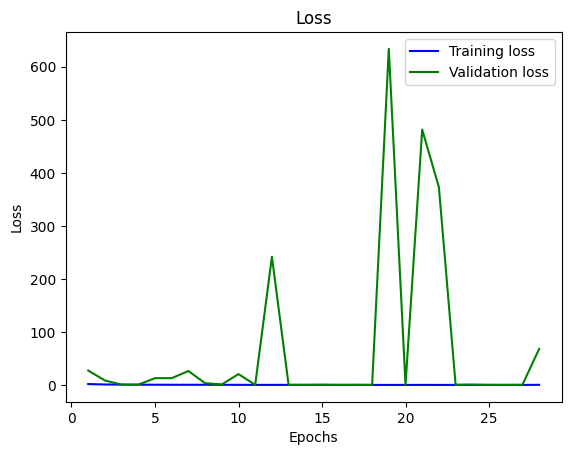

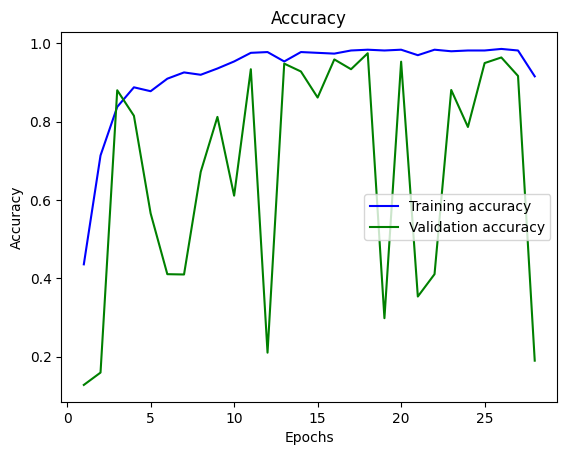

In [60]:
plot_history(hist)

#### It seems that you encountered a `NameError` for `math` in the code block. To resolve this, ensure you import the `math` module at the beginning of your script. Add `import math` alongside other import statements. This will resolve the `NameError` and allow you to correctly calculate the number of steps for making predictions.

In [63]:
# Load the saved model
saved_model = load_model('best_model.keras')  # Use the correct path and filename

# Calculate the correct number of steps based on your batch size and total number of test files
num_test_samples = len(test_set_files)  # Make sure this is correctly calculated or set
batch_size = 32
steps = math.ceil(num_test_samples / batch_size)

# Make predictions
test_pred = saved_model.predict(featureGenerator(test_set_files, test_classes, batch_size=batch_size), steps=steps, verbose=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step


#### This code segment first identifies the predicted class labels by finding the indices with the highest probability in the prediction array. Then, it employs the `inverse_transform` method of the `LabelEncoder` to convert these indices back into their original class labels, providing human-readable predictions for evaluation or further analysis.

In [64]:

# Get the indices of the max logit, which are the class labels
predictions_int = np.argmax(test_pred, axis=1)

# Use the LabelEncoder to transform these indices back to the original class labels
predictions_labels = labelencoder.inverse_transform(predictions_int)


In [65]:
print(len(predictions_int))
print(predictions_int)
print(len(predictions_labels))
print(predictions_labels)
print(len(classes_num[test_index]))
print(classes_num[test_index])

195
[1 1 1 6 6 0 3 7 5 6 2 0 2 5 7 3 6 3 6 0 3 1 3 6 5 4 7 0 5 6 3 7 5 7 4 5 7
 5 2 7 5 7 5 3 3 0 4 4 4 7 6 6 1 1 3 2 1 7 6 0 0 1 0 3 6 2 2 1 1 7 1 0 4 7
 5 0 0 7 4 2 4 2 4 3 7 7 6 7 4 4 1 2 4 0 6 6 5 7 4 0 4 4 5 7 0 7 6 2 6 5 4
 1 1 2 3 2 1 7 2 4 0 3 2 4 6 3 5 5 1 1 1 4 2 1 2 7 7 1 4 6 5 7 2 3 5 2 2 7
 0 6 7 4 4 0 6 0 4 1 3 2 7 5 0 5 2 0 4 7 2 3 7 5 6 7 0 5 5 2 5 4 0 6 1 6 5
 2 1 3 6 2 3 6 0 3 7]
195
['contrabassoon' 'contrabassoon' 'contrabassoon' 'trumpet' 'trumpet'
 'cello' 'mandolin' 'viola' 'sax' 'trumpet' 'flute' 'cello' 'flute' 'sax'
 'viola' 'mandolin' 'trumpet' 'mandolin' 'trumpet' 'cello' 'mandolin'
 'contrabassoon' 'mandolin' 'trumpet' 'sax' 'oboe' 'viola' 'cello' 'sax'
 'trumpet' 'mandolin' 'viola' 'sax' 'viola' 'oboe' 'sax' 'viola' 'sax'
 'flute' 'viola' 'sax' 'viola' 'sax' 'mandolin' 'mandolin' 'cello' 'oboe'
 'oboe' 'oboe' 'viola' 'trumpet' 'trumpet' 'contrabassoon' 'contrabassoon'
 'mandolin' 'flute' 'contrabassoon' 'viola' 'trumpet' 'cello' 'cello'
 'contrabassoon' 'c

##### This code computes several evaluation metrics for the classification model's performance. It calculates the recall, precision, F1-score, and accuracy using functions provided by scikit-learn. The results are printed out, providing insights into the model's performance across different classes, including the overall accuracy and the number of correctly classified samples. Additionally, a comprehensive classification report is generated, offering a detailed breakdown of performance metrics for each class.

In [66]:
# Assuming predictions_int and classes_num[test_index] are correctly defined and contain the predicted and true labels, respectively.

# Calculate and print Recall
recall_results = recall_score(classes_num[test_index], predictions_int, average=None)
print("Recall: ", recall_results)

# Calculate and print Precision
precision_results = precision_score(classes_num[test_index], predictions_int, average=None)
print("Precision: ", precision_results)

# Calculate and print F1-Score
f1_results = f1_score(classes_num[test_index], predictions_int, average=None)
print("F1-Score: ", f1_results)

# Calculate and print Accuracy
accuracy_result = accuracy_score(classes_num[test_index], predictions_int, normalize=True)
total_correct = accuracy_score(classes_num[test_index], predictions_int, normalize=False)
print("Accuracy: %.2f, Total Correct: %d" % (accuracy_result, total_correct))
print("Number of samples:", classes_num[test_index].shape[0])

# Generate and print a full classification report
class_report = classification_report(classes_num[test_index], predictions_int)
print(class_report)


Recall:  [0.92 0.92 1.   1.   1.   0.96 1.   1.  ]
Precision:  [1.   1.   1.   1.   1.   1.   1.   0.83]
F1-Score:  [0.96 0.96 1.   1.   1.   0.98 1.   0.91]
Accuracy: 0.97, Total Correct: 190
Number of samples: 195
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       1.00      0.92      0.96        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        25
           5       1.00      0.96      0.98        25
           6       1.00      1.00      1.00        25
           7       0.83      1.00      0.91        25

    accuracy                           0.97       195
   macro avg       0.98      0.97      0.98       195
weighted avg       0.98      0.97      0.98       195



#### This function plots a confusion matrix, which is a visual representation of the model's performance in classifying the test data. It takes the confusion matrix `cm`, a list of class names `classes`, and optional parameters to normalize the matrix and set the title and color map. The matrix is displayed with colored cells representing the number of true positives, false positives, true negatives, and false negatives for each class.

### Function to Plot Confusion Matrix
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [73]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

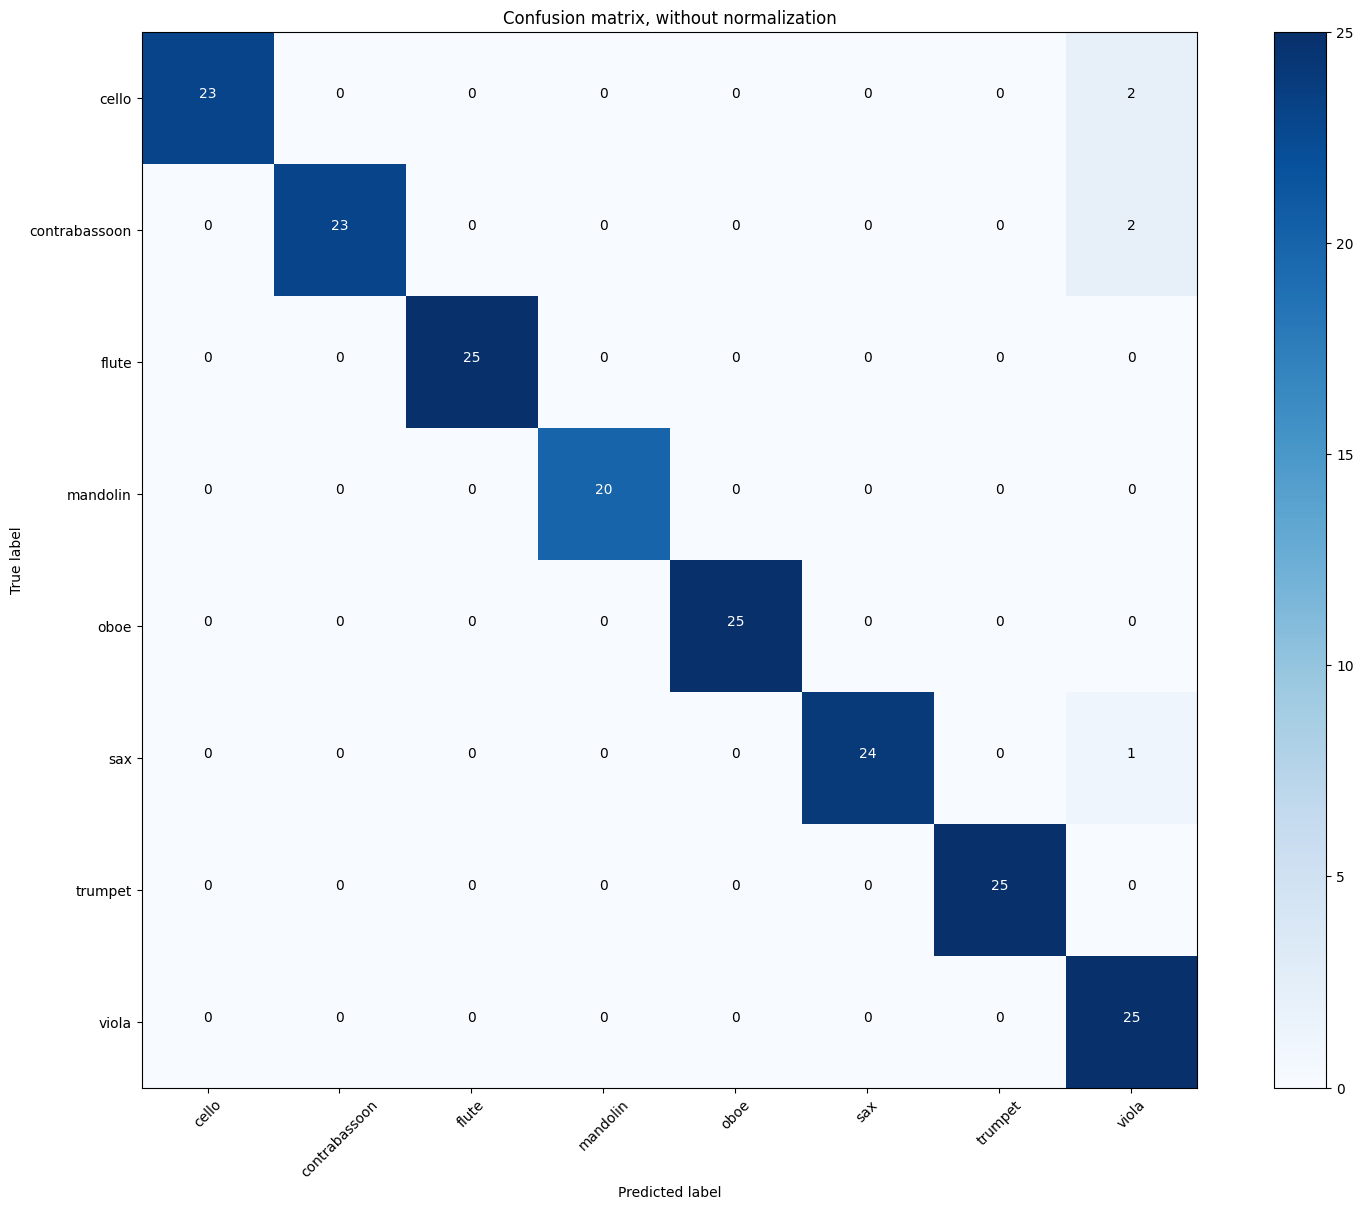

In [69]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

##### This code snippet creates a list `wrong_predictions` containing the indexes of samples where the predicted label does not match the true label. It iterates over pairs of true labels (`e1`) and predicted labels (`e2`) in the test set, identifying the indexes (`i`) where they differ.

In [70]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(classes_num[test_index], predictions_int)) if e1 != e2]


In [71]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['sax' 'cello' 'cello' 'contrabassoon' 'contrabassoon']
['viola' 'viola' 'viola' 'viola' 'viola']
['./audio/sax\\saxophone_Gs3_05_pianissimo_normal.mp3'
 './audio/cello\\cello_Gs4_025_mezzo-forte_arco-col-legno-battuto.mp3'
 './audio/cello\\cello_A3_025_mezzo-piano_arco-normal.mp3'
 './audio/contrabassoon\\contrabassoon_A3_very-long_piano_normal.mp3'
 './audio/contrabassoon\\contrabassoon_As1_very-long_cresc-decresc_normal.mp3']


In [72]:
# Extract features (e.g., MFCCs)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print("MFCCs Shape:", mfccs.shape)


MFCCs Shape: (13, 87)
